In [71]:
import pandas as pd
import numpy as np
from konlpy.tag import Kkma
import re
from tqdm import tqdm
from collections import Counter
from string import punctuation # 구두점을 제거하는데 필요
from konlpy.tag import Mecab
import itertools
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
# 데이터 불러오기
df = pd.read_csv("/home/ubuntu/zzm_modelserver/datas/final_list_qtype.csv")
df

,corp_nm,job,recruit_date,new_or_exp,q1,a1,q2,a2,q3,a3,q4,a4,q5,a5,q1_type,q2_type,q3_type,q4_type,q5_type
0,NaN,NaN,201610.0,NaN,당신의 성장과정에 대해 기술하시오,500내외 저는 목표와 계획을 바탕으로 그 일을 끝까지 밀고 나가는 추진력을 몸...,코오롱에 지원하게 된 동기와 지원한 분야를 위해 어떤 노력과 준비를 해왔는지 기술하시오,"“실속 있다”라는 말이 있습니다 이 말은 겉모습만을 보고 판단하는 것이 아니라, 그...","아래의 단어를 기준으로 당신의 성격을 점수로 표현하고, 성격의 장단점에 대해 간략히...",제 성격의 가장 큰 장점은 매사에 긍정적인 태도에 임한다는 것입니다. 저는 긍정적인...,NaN,NaN,NaN,NaN,2.0,1.0,4.0,NaN,NaN
1,NaN,연구개발,202011.0,NaN,삼성전자판매를 지원한 동기 및 입사 후 이루고 싶은 꿈을 기술하시기 바랍니다,[결국은 삼성전자] 대한민국 국민들은 전자제품 회사 선택의 폭이 넓은 행운을 갖고 ...,최근 사회이슈 중 중요하다고 생각되는 한 가지를 선택하고 이에 관한 자신의 견해를 ...,[코로나19 이슈로 보는 자유민주주의의 딜레마] 코로나19 이슈에서 자유민주주의의 ...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.0,NaN,NaN,NaN
2,NaN,NaN,202011.0,NaN,인성 및 성격의 장단점,저는 목표를 위한 계획을 단계적으로 수립하고 실천하는 성격입니다. 차례대로 계획한 ...,지원동기 및 입사 후 포부,최근 친환경 에너지를 향한 관심이 급증하고 있습니다. 이에 따라 전기자동차에 관한 ...,학교생활 및 특별활동 경험,"해외연수, 봉사활동, 입상경험, 단체활동 등) (500자) 저는 대학교 1학년 때부...",전공 관련 주요 관심분야 및 논문소개,저는 고분자 물질을 설계하고 합성하여 실용적인 제품을 만드는 데 관심이 많습니다. ...,NaN,NaN,4.0,0.0,3.0,6.0,NaN
3,NaN,NaN,201610.0,NaN,자신의 성장과정과 학창시절을 기술하여 주십시오,"[외향적인 아이, 소통을 배움으로 성장하다.]학창 시절의 저는 털털하고, 사람들에게...",지원 직무 관련 자신이 갖춘 역량에 대하여 구체적으로 기술하여 주십시오,"[성실함, 그것은 가장 큰 무기]현재 저는 석사과정 학생으로, 실험실에서 실험을 하...",지원 사업부 또는 직무에 지원하게 된 동기와 본인이 지원하는 사업부의 시장 경쟁력을...,"[고분자 중합의 선도자 '효성기술원', 그리고 미래]제가 효성기술원에 지원하게 된 ...",NaN,NaN,NaN,NaN,2.0,3.0,0.0,NaN,NaN
4,NaN,NaN,201510.0,NaN,지원동기,"다양한 유통업 현장에서 나를 발견하다] 400자군 제대후, 대형마트 계산원, 핸드폰...",성장과정 400자,쇼핑몰 창업경험]예전의 저는 평소 새로운 일에 도전하는걸 두려워 했던 학생이었습니다...,입사후 포부 400자,고객의 마음을 읽는 영업인재]다양한 서비스직 아르바이트를 통해 사람의 마음을 헤아리...,성격의 장단점 및 보완노력,Yes man]늘 누구에게나 좋은 사람으로 비춰지고 싶은 욕심에 주변 분들의 부탁에...,정직함에 대하여,진솔함을 통한 정직함] 대학생활중 항상 많은 과제와 잦은 수업보충으로 인해 수강생들...,0.0,2.0,0.0,4.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18448,오비맥주,유통·물류·재고,201503.0,인턴,성장과정,저는 어린 시절 농구를 좋아해 농구화를 사고 싶어 아르바이트를 했습니다. 큰 돈은 ...,성격의 장단점,저의 장점은 성실함과 유연한 대응 능력입니다. 대학에 입학하고 성인이 되어 내 생활...,지원동기,"능력을 갖춘 유통, 물류 전문가가 되기 위하여 OB맥주에서의 경험은 저에게 중요한 ...",입사 후 포부,OB 맥주는 우리나라 주류유통을 선도하고 더 나아가 세계최대맥주그룹인 AB인브베와 ...,NaN,NaN,2.0,4.0,0.0,0.0,NaN
18449,삼화페인트공업,화학·에너지·환경,201603.0,신입,"본인의 성격, 성장과정, 가치관 등을 기술하시오.","남들을 배려하며 착하게 사는 것이 옳다고 배우며 살아왔기 때문에, 이타적인 성향이 ...",본인 해당직무를 지원한 동기 및 이를 위해 준비해온 과정을 기술하시오.,"개발된 제품 소재들의 물성(효율), 생산성 등을 개선하는 등의 연구개발에 참여하고 ...",삼화페인트 인재상 중 자신과 근접한 항목과 향후 보완이 필요한 항목에 대해 구체적으...,"맡겨진 업무를 반드시 해결하고, 끊임없이 보완할 점을 찾는 점입니다. 석사로 입학하...",삼화페인트에 지원한 동기와 향후 목표에 대해 기술하시오.,석사과정에서 현장실습 견학으로 삼화페인트 연구소에 다녀간 후로 관심을 갖게 되었습니...,NaN,NaN,2.0,0.0,4.0,0.0,NaN
18450,LG디스플레이,생산관리·공정관리·품질관리,201509.0,신입,LG디스플레이 및 지원 직무에 지원하는 동기에 대해 기술해 주십시오. (500~10...,"2013년 여름, 천호식품에서 아르바이트를 했었습니다. 제품 생산에서부터 포장, 운...",도전적인 목표를 정하고 열정적으로 일을 추진했던 경험을 구체적으로 기술해 주십시오....,[실패로서 얻는 경험] `창업 지원 공모전`에 참가했습니다. 4번의 심사를 통과하면...,디스플레이 및 지원 직무 관련된 이력을 간결하게 나열해주시기 바랍니다. (100 ~...,공학윤리(2010) / B+ 기계공작법(2013) / B+ 기계공작법실습(2014)...,NaN,NaN,NaN,NaN,0.0,1.0,0.0,NaN,NaN
18451,엘에스전선,생산·제조·설비·조립,201509.0,신입,"본인에 대하여 소개해 주시기 바랍니다. (성장과정, 경험, 성격, 강/약점, 가치관...",[노력하는 인재] 선배들의 추천을 받아 13년도 동아리 회장을 맡았습니다. 당시 숫...,"본인이 속했던 조직(ex. 친구, 동아리, 가족, 기타모임 등)의 화합과 융화를 이...",[`무엇인가`를 배웠습니다] 봉사활동을 처음 시작할 당시 봉사시간보다는 누군가를 만...,"본인 스스로 최고가 되기 위해 노력했던 경험에 대해서 작성해 주시고, 당사 지원 직...",[To be the best? To do my best!!] 가장 높은 자리에 올라...,"누군가를 감동시키기 위해 노력했던 경험과, 그러한 노력이 상대방에게 어떻게 받아들여...","[함께한다는 것, 그 이상의 의미] 대학생활을 함께한 모임, 새앎터가 있습니다. 환...",NaN,NaN,2.0,2.0,3.0,1.0,NaN


In [73]:
def textcount(input):
    df['corp_nm'].fillna('미입력', inplace=True) # Nan값 전처리
    title_df = df[df['corp_nm'].str.contains(input, na=False)]
    etc2 = title_df[['a1', 'a2', 'a3', 'a4', 'a5']].values.astype(str).tolist()
    
    
    def strip_punctuation(s):
        return ''.join(c for c in s if c not in punctuation)

    clean_title = []
    for sent in etc2 :
        clean = strip_punctuation(sent)
        clean_title.append(clean)
    
    m = Mecab()
    dataset = []
    for i in range(len(clean_title)) :
        dataset.append(m.nouns(re.sub('[^가-힣a-zA-Z\s]', '', clean_title[i])))
        
    stopwords = [input]
    f = open("/home/ubuntu/zzm_modelserver/datas/stopwords.txt", encoding='UTF8')
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        stopwords.append(line)
    f.close()

    def cleansing(document):
        corpus = []
        for d in document:
            doc = []
            for word in d:
                low_word = word.lower()
                if (low_word not in stopwords) and (len(low_word)!=1):
                    doc.append(word)
            corpus.append(doc)
        return corpus

    
    dataset = cleansing(dataset)
    dataset2 = sum(dataset, [])
    count = Counter(dataset2)
    korean = count.most_common(20)
    
    return korean

In [74]:
textcount('삼성전자')

[('기술', 3630),
 ('반도체', 3394),
 ('삼성', 2271),
 ('경험', 2185),
 ('기업', 2160),
 ('개발', 2144),
 ('제품', 1922),
 ('시장', 1867),
 ('공정', 1851),
 ('문제', 1714),
 ('노력', 1659),
 ('도전', 1452),
 ('세계', 1440),
 ('성장', 1400),
 ('목표', 1370),
 ('산업', 1362),
 ('필요', 1338),
 ('발전', 1243),
 ('결과', 1210),
 ('과정', 1197)]

In [75]:
def networkdiagram(input):
    
    a = []
    for v,b in textcount(input):
        a.append(v)

    G = nx.Graph()
    G.add_nodes_from([( input, {"count": 500 })])
    G.add_nodes_from([(tag, {"count":count}) for tag, count in textcount(input)])
    G.add_edges_from([ ( input, edge ) for edge in a ])

    plt.figure(figsize=(20,20))
    pos = nx.spring_layout(G, k=0.5) 
    node_size = [ d['count']*50 for (n,d) in G.nodes(data=True)] 
    nx.draw_networkx_nodes(G, pos, node_color='b', alpha=0.2, node_size=node_size)
    nx.draw_networkx_labels(G, pos, font_size=14, font_family='/user/share/fonts/nanum/NanumGothicBold.ttf')
    # edge_width = [ d['weight']*0.5 for (u,v,d) in G.edges(data=True)] 
    nx.draw_networkx_edges(G, pos, alpha=0.1, edge_color='black')
    plt.axis('off')

findfont: Font family '/user/share/fonts/nanum/NanumGothicBold.ttf' not found.
findfont: Font family '/user/share/fonts/nanum/NanumGothicBold.ttf' not found.
/home/ubuntu/anaconda3/envs/zzm/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from current font.
  func(*args, **kwargs)
/home/ubuntu/anaconda3/envs/zzm/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  func(*args, **kwargs)
findfont: Font family '/user/share/fonts/nanum/NanumGothicBold.ttf' not found.
findfont: Font family '/user/share/fonts/nanum/NanumGothicBold.ttf' not found.
/home/ubuntu/anaconda3/envs/zzm/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  func(*args, **kwargs)
/home/ubuntu/anaconda3/envs/zzm/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 49437 (\N{HANG

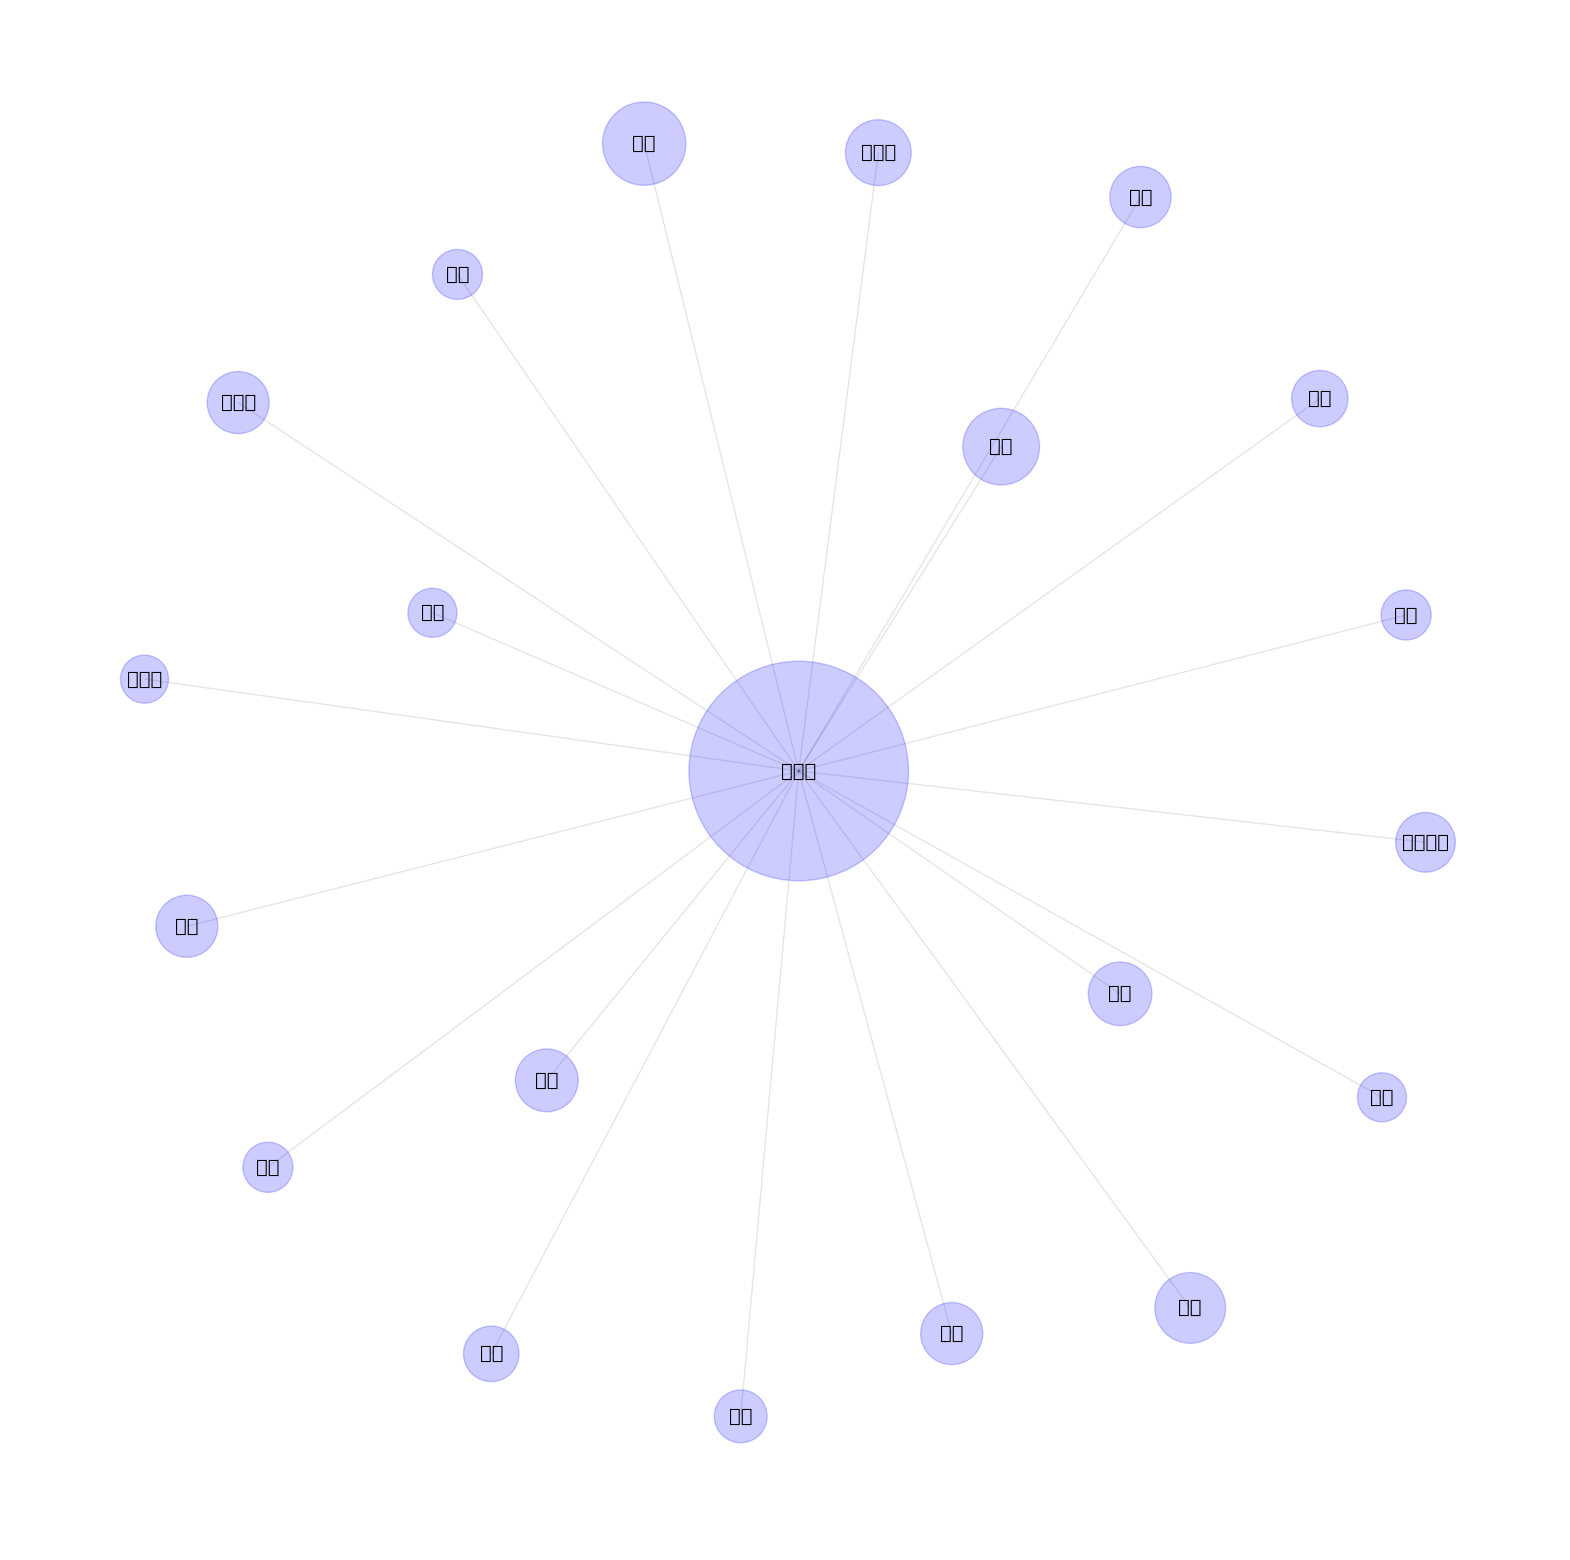

In [76]:
networkdiagram('카카오')